In [1]:
import os
import re
import glob
import struct
from os import makedirs

import numpy as np
from numpy import asarray
from numpy import zeros
from nltk.stem.porter import *


import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Reshape, Conv2D, MaxPool2D, Dense, Dropout, Flatten, Embedding, Concatenate, Conv1D
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras import regularizers
from keras import backend as K
from keras.models import load_model

import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier

import matplotlib.pyplot as plt


Load the Dataset


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/twit/train")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "aggregate.csv", index=False, encoding='utf-8-sig')

In [4]:
names = ['TweetID', 'Sentiment', 'Tweet']

train = pd.read_csv('/content/drive/MyDrive/twit/train/aggregate.csv')

train.head()

,Column1,Column2,Column3
0,1.551359e+09,negative,@Descending yeah yeah offer it now I'm halfway...
1,2.191006e+09,positive,"@coopes64 someone tweeted it this time, but I'..."
2,1.556787e+09,negative,BTW I Don't live in the country I am Suburbia...
3,1.557363e+09,negative,@tiaralynn lol. i got the bg from createblog.c...
4,2.190198e+09,positive,"@juzferyou well, not all that cheap i reckon b..."


Data Preprocessing

In [5]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

def clean_tweets(frame, column_name):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words

  return frame

In [6]:
train_set = clean_tweets(train, 'Column3')
train_set.head()

,Column1,Column2,Column3,Tweet_Clean_Text
0,1.551359e+09,negative,@Descending yeah yeah offer it now I'm halfway...,yeah yeah offer it now I m halfway home
1,2.191006e+09,positive,"@coopes64 someone tweeted it this time, but I'...",someone tweeted it this time but I ve seen it...
2,1.556787e+09,negative,BTW I Don't live in the country I am Suburbia...,BTW I Don t live in the country I am Suburbia ...
3,1.557363e+09,negative,@tiaralynn lol. i got the bg from createblog.c...,lol i got the bg from createblog com i was go...
4,2.190198e+09,positive,"@juzferyou well, not all that cheap i reckon b...",well not all that cheap i reckon but cute def...


In [7]:
train_set["Sentiment_Value"] = train_set["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
label = to_categorical(train_set["Sentiment_Value"], 3)
train_set

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,1.551359e+09,negative,@Descending yeah yeah offer it now I'm halfway...,yeah yeah offer it now I m halfway home,2
1,2.191006e+09,positive,"@coopes64 someone tweeted it this time, but I'...",someone tweeted it this time but I ve seen it...,1
2,1.556787e+09,negative,BTW I Don't live in the country I am Suburbia...,BTW I Don t live in the country I am Suburbia ...,2
3,1.557363e+09,negative,@tiaralynn lol. i got the bg from createblog.c...,lol i got the bg from createblog com i was go...,2
4,2.190198e+09,positive,"@juzferyou well, not all that cheap i reckon b...",well not all that cheap i reckon but cute def...,1
...,...,...,...,...,...
114213,6.390170e+17,neutral,@YouAreMyArsenal Wouldn't surprise me if we en...,Wouldn t surprise me if we enquired He can t ...,0
114214,6.402770e+17,neutral,Rib injury for Zlatan against Russia is a big ...,Rib injury for Zlatan against Russia is a big ...,0
114215,6.402970e+17,neutral,Noooooo! I was hoping to see Zlatan being Zlat...,Noooooo I was hoping to see Zlatan being Zlata...,0
114216,6.410170e+17,neutral,@Fronsoir Zlatan has never done it on a wet Tu...,Zlatan has never done it on a wet Tuesday nig...,0


In [8]:
y_labels = train_set['Sentiment_Value']
y_labels.shape

(114218,)

In [9]:
train['l'] = train_set['Tweet_Clean_Text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(train.l.mean()))
print("max length of sentence: " + str(train.l.max()))
print("std dev length of sentence: " + str(train.l.std()))

mean length of sentence: 17.38020277014131
max length of sentence: 47.0
std dev length of sentence: 6.9299730337355


In [10]:
sequence_length = 47 #using the maximum length 

In [11]:
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(train_set['Tweet_Clean_Text'].values)

X = tokenizer.texts_to_sequences(train_set['Tweet_Clean_Text'].values)
X = pad_sequences(X, sequence_length)
x_train = X

print("training size " + str(len(x_train)))

voc_size = len(tokenizer.word_index) + 1
print("Vocab size: ", voc_size)
print("Input shape: ", x_train.shape)
print("Y_shape: " , y_labels.shape)

training size 114218
Vocab size:  63987
Input shape:  (114218, 47)
Y_shape:  (114218,)


Spliting the dataset

In [12]:
x_train, X_test, y_labels, Y_test = train_test_split(x_train, y_labels, test_size=0.10, shuffle=False, random_state=10)

X_train, X_dev, Y_train, Y_dev = train_test_split(x_train, y_labels, test_size=0.15, shuffle=True, random_state=10)

GloVe Embedding

In [13]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [14]:
embedding_dim = 200
embedding_matrix = np.zeros((voc_size, embedding_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Metrics

In [15]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
from keras.utils import to_categorical
from keras import layers

def model_gen(filter_sizes):

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath= 'models/flatCNN' + str(filter_sizes) + '.h5',
      save_weights_only = False,
      monitor = 'val_f1',
      mode= 'max',
      save_best_only= True
  )

  early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

  reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=2, min_lr=0.00001)

  output_dims = 200
  lstm_out = filter_sizes

  model = keras.Sequential([
      layers.Embedding(input_dim=voc_size, output_dim=output_dims, input_length=X.shape[1], weights=[embedding_matrix]),
      layers.SpatialDropout1D(0.2),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)),
      layers.Dense(units=3, activation='softmax')
      ])

  metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
           #keras.metrics.TruePositives(name='tp'),
           #keras.metrics.FalsePositives(name='fp'),
           #keras.metrics.TrueNegatives(name='tn'),
           #keras.metrics.FalseNegatives(name='fn'),
  ]

  model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=metrics
              )

  history = model.fit(X_train,
                    to_categorical(Y_train),
                    batch_size=3000,
                    epochs=20,
                    validation_split=0.05,
                    shuffle=True,
                    callbacks=[model_checkpoint, early_stopping_callback, reduce_lr_callback]
  )

  return model, history




In [18]:
filter_sizes = [
                200,256,352,456,532
                ]
models = []
best_indiv = 0.0
for filter_size in filter_sizes:
  model, history = model_gen(filter_size)
  models.append(model)
  best_indiv = max(best_indiv, max(history.history['val_f1']))

Epoch 1/20
28/28 [==============================] - 24s 721ms/step - loss: 1.0036 - categorical_accuracy: 0.4899 - precision: 0.6512 - recall: 0.1527 - f1: 0.2085 - val_loss: 0.7732 - val_categorical_accuracy: 0.6580 - val_precision: 0.6928 - val_recall: 0.5848 - val_f1: 0.6326
Epoch 2/20
28/28 [==============================] - 20s 707ms/step - loss: 0.7752 - categorical_accuracy: 0.6454 - precision: 0.6882 - recall: 0.5671 - f1: 0.6218 - val_loss: 0.7032 - val_categorical_accuracy: 0.6901 - val_precision: 0.7211 - val_recall: 0.6304 - val_f1: 0.6717
Epoch 3/20
28/28 [==============================] - 20s 709ms/step - loss: 0.7176 - categorical_accuracy: 0.6782 - precision: 0.7149 - recall: 0.6106 - f1: 0.6586 - val_loss: 0.6829 - val_categorical_accuracy: 0.6986 - val_precision: 0.7424 - val_recall: 0.6411 - val_f1: 0.6869
Epoch 4/20
28/28 [==============================] - 20s 711ms/step - loss: 0.6948 - categorical_accuracy: 0.6874 - precision: 0.7239 - recall: 0.6271 - f1: 0.6720 

In [19]:
best_indiv

0.7284016013145447

In [20]:
train_predictions_flat_CNN = []
test_predictions_flat_CNN = []

for model in models:
  train_predictions_flat_CNN.append(model.predict([X_train], batch_size=1024))
  test_predictions_flat_CNN.append(model.predict([X_dev], batch_size=1024))

In [ ]:
ndarray = np.array(train_predictions_flat_CNN)
positive = ndarray[:,:,0]
neutral = ndarray[:,:,1]
negative = ndarray[:,:,2]

average = (np.corrcoef(positive) + np.corrcoef(neutral) + np.corrcoef(negative))/3
average

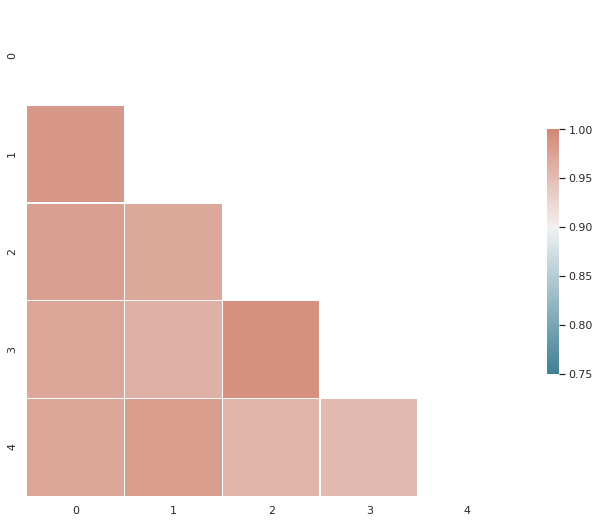

In [22]:
import seaborn as sns

sns.set_theme(style="white")

mask = np.triu(np.ones_like(average, dtype=bool))

f, ax = plt.subplots(figsize=(11,9))

cmap = sns.diverging_palette(220,20, n=9, as_cmap=True)

sns.heatmap(average, mask=mask, cmap=cmap, vmax=1, vmin=.75, center=.9,
            square=True, linewidth=.5, cbar_kws={"shrink":.5})